In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import catboost as cb
%matplotlib inline

# load data sources

In [2]:
train = pd.read_csv("/home/alex/Downloads/kaggle/competition/train.csv")
test = pd.read_csv("/home/alex/Downloads/kaggle/competition/test.csv")
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols


In [3]:
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [4]:
applications_history = pd.read_csv("/home/alex/Downloads/kaggle/competition/applications_history.csv")

print("applications_history.shape = {} rows, {} cols".format(*applications_history.shape))

applications_history.shape = 1670214 rows, 26 cols


In [5]:
applications_history.head(2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [6]:
client_profile = pd.read_csv("/home/alex/Downloads/kaggle/competition/client_profile.csv")

print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))

client_profile.shape = 250000 rows, 24 cols


In [7]:
client_profile.head(2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
bki = pd.read_csv("/home/alex/Downloads/kaggle/competition/bki.csv")

print("bki.shape = {} rows, {} cols".format(*bki.shape))

bki.shape = 945234 rows, 17 cols


In [9]:
payments = pd.read_csv("/home/alex/Downloads/kaggle/competition/payments.csv")

print("payments.shape = {} rows, {} cols".format(*payments.shape))

payments.shape = 1023932 rows, 8 cols


# eda

## applications_history

In [10]:
applications_history.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,4.919130e+07,1.236017e+08,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,3.139511e+02,1.605408e+01,342340.056543,15949.224065,35163.363265,78152.730207,83505.775017,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,7.127443e+03,1.456729e+01,88413.495220,72007.270877,106405.950190,148833.342466,152484.418802,0.471134
min,4.826822e+07,1.234233e+08,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,4.873007e+07,1.235127e+08,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,-1.000000e+00,6.000000e+00,365243.000000,475.000000,257.000000,455.000000,447.000000,0.000000
50%,4.919132e+07,1.236021e+08,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,921.000000,741.000000,1155.000000,1171.000000,0.000000
75%,4.965249e+07,1.236909e+08,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,8.200000e+01,2.400000e+01,365243.000000,1825.000000,1735.000000,2418.000000,2501.000000,1.000000
max,5.011360e+07,1.237796e+08,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [11]:
applications_history.shape

(1670214, 26)

In [12]:
print(applications_history.columns)
print(applications_history.columns.shape)

Index(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE',
       'AMOUNT_ANNUITY', 'AMT_APPLICATION', 'AMOUNT_CREDIT', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'NAME_YIELD_GROUP', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')
(26,)


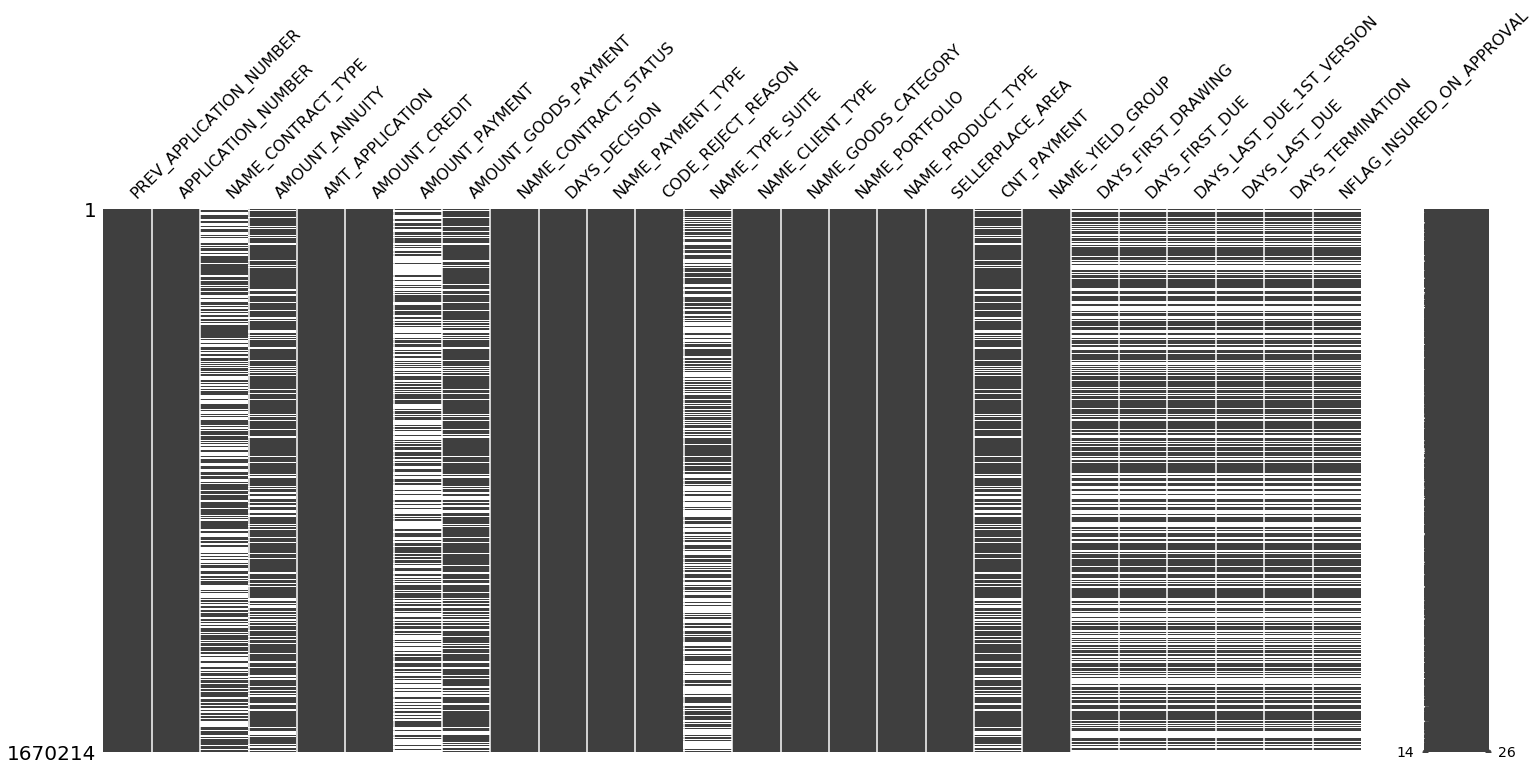

In [13]:
msno.matrix(applications_history)

Данные имеют большое количество пропусков

In [14]:
applications_history_numerical_features = applications_history.select_dtypes(include=[np.number])
print(f"count of applications_history_numeric_features {applications_history_numerical_features.shape[1]}")
applications_history_numerical_features.head(2)

count of applications_history_numeric_features 16


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,1730.430,17145.0,17145.0,0.0,17145.0,73,35,12.0,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,25188.615,607500.0,679671.0,NaN,607500.0,164,-1,36.0,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [15]:
applications_history_categorical_features = applications_history.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {applications_history_categorical_features.shape[1]}")
applications_history_categorical_features.head(2)

Categorical Feature Count 10


,NAME_CONTRACT_TYPE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP
0,NaN,Approved,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,middle
1,Cash,Approved,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,low_action


Данные имеют как числовые так и категориальные фичи. Разберём их подробнее

In [16]:
applications_history_discrete_feature = [
    feature for feature in applications_history_numerical_features
    if len(applications_history[feature].unique())<25
]

print(f"Discrete Variables Count: {len(applications_history_discrete_feature)}")

Discrete Variables Count: 1


In [17]:
applications_history_continuous_feature = [
    feature for feature in applications_history_numerical_features
    if feature not in ["TARGET"] + applications_history_discrete_feature]

print(f"Continuous Feature Count {len(applications_history_continuous_feature)}")

Continuous Feature Count 15


## client_profile

In [18]:
client_profile.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,...,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,...,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,...,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,...,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,...,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,...,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,...,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,...,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [19]:
client_profile.shape

(250000, 24)

In [20]:
print(client_profile.columns)
print(client_profile.columns.shape)

Index(['APPLICATION_NUMBER', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')
(24,)


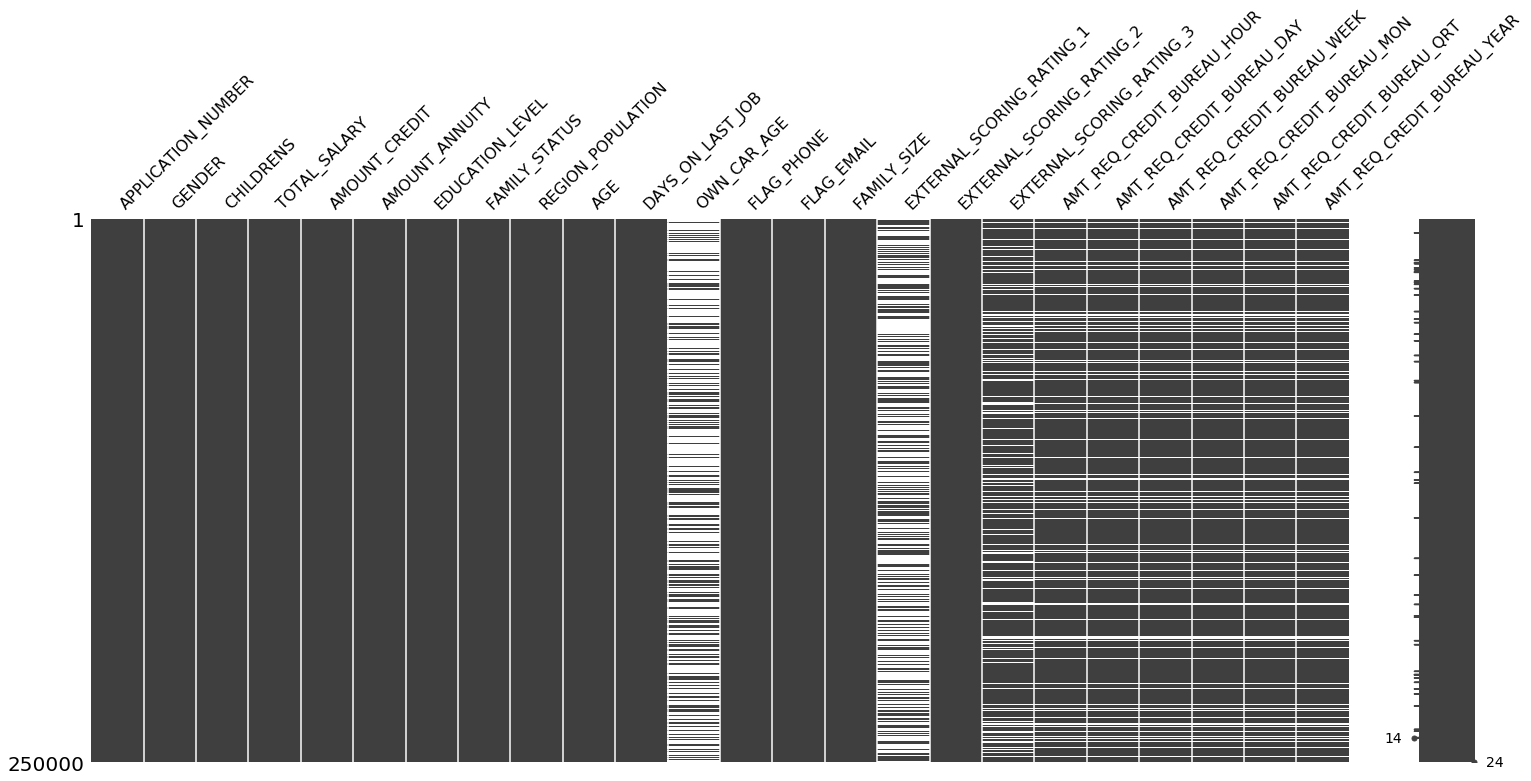

In [21]:
msno.matrix(client_profile)

In [22]:
client_profile_numerical_features = client_profile.select_dtypes(include=[np.number])
print(f"count of client_profile_numeric_features {client_profile_numerical_features.shape[1]}")
client_profile_numerical_features.head(2)

count of client_profile_numeric_features 21


,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,0,157500.0,270000.0,13500.0,0.008068,8560,1549,NaN,1,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,0,270000.0,536917.5,28467.0,0.020246,23187,365243,NaN,0,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [23]:
client_profile_categorical_features = client_profile.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {client_profile_categorical_features.shape[1]}")
client_profile_categorical_features.head(2)

Categorical Feature Count 3


,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
0,F,Incomplete higher,Civil marriage
1,F,Secondary / secondary special,Married


In [24]:
client_profile_discrete_feature = [
    feature for feature in client_profile_numerical_features
    if len(client_profile[feature].unique())<25
]

print(f"Discrete Variables Count: {len(client_profile_discrete_feature)}")

Discrete Variables Count: 8


In [25]:
client_profile_continuous_feature = [
    feature for feature in client_profile_numerical_features
    if feature not in ["TARGET"] + client_profile_discrete_feature]

print(f"Continuous Feature Count {len(client_profile_continuous_feature)}")

Continuous Feature Count 13


## bki

In [26]:
bki.describe()

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,9.452340e+05,9.452340e+05,945234.000000,945234.000000,886797.000000,596274.000000,3.265570e+05,945234.000000,9.452290e+05,8.034830e+05,6.192670e+05,9.452340e+05,945234.000000,2.693300e+05
mean,1.236016e+08,5.974377e+06,1142.218231,0.769791,1819.607174,1018.001196,3.784219e+03,0.006330,3.547738e+05,1.361747e+05,6.267718e+03,3.826128e+01,594.056297,1.646679e+04
std,1.029041e+05,5.330431e+05,795.047305,35.173550,4684.447770,715.013564,2.133823e+05,0.094857,1.078781e+06,6.370282e+05,4.528027e+04,5.156032e+03,721.505604,3.937657e+05
min,1.234233e+08,5.001084e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000,0.000000e+00
25%,1.235122e+08,5.513773e+06,474.000000,0.000000,383.000000,426.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,0.000000e+00,0.000000e+00,33.000000,0.000000e+00
50%,1.236014e+08,5.976502e+06,987.000000,0.000000,863.000000,897.000000,0.000000e+00,0.000000,1.254708e+05,0.000000e+00,0.000000e+00,0.000000e+00,396.000000,0.000000e+00
75%,1.236908e+08,6.435551e+06,1666.000000,0.000000,1504.000000,1489.000000,0.000000e+00,0.000000,3.150000e+05,3.973275e+04,0.000000e+00,0.000000e+00,908.000000,1.350000e+04
max,1.237796e+08,6.942186e+06,2922.000000,2792.000000,42060.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,41943.000000,1.184534e+08


In [27]:
bki.shape

(945234, 17)

In [28]:
print(bki.columns)
print(bki.columns.shape)

Index(['APPLICATION_NUMBER', 'BUREAU_ID', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')
(17,)


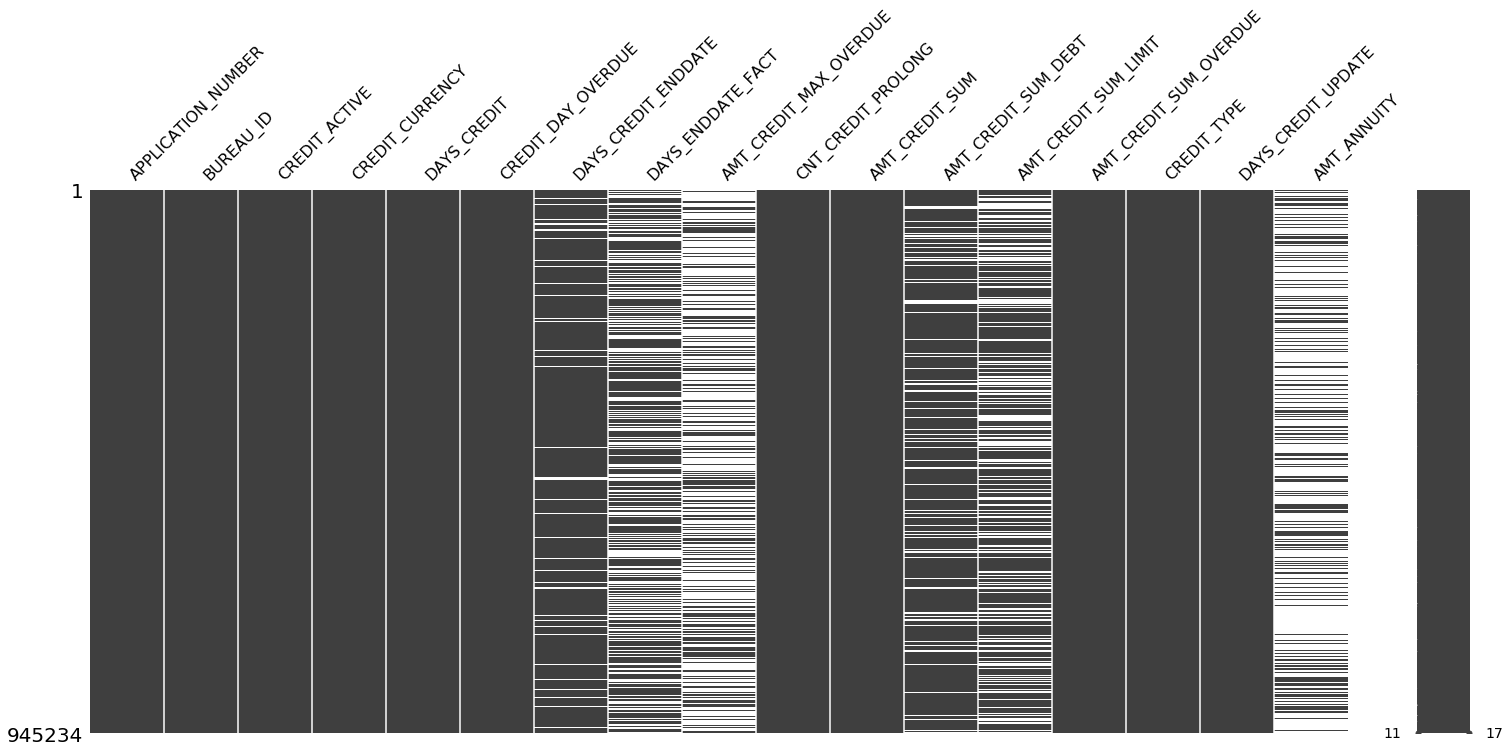

In [29]:
msno.matrix(bki)

In [30]:
bki_numerical_features = bki.select_dtypes(include=[np.number])
print(f"count of bki_numeric_features {bki_numerical_features.shape[1]}")
bki_numerical_features.head(2)

count of bki_numeric_features 14


,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,39.0,NaN
1,123436670,6207544,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,505.0,NaN


In [31]:
bki_categorical_features = bki.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {bki_categorical_features.shape[1]}")
bki_categorical_features.head(2)

Categorical Feature Count 3


,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
0,Active,currency 1,Consumer credit
1,Closed,currency 1,Consumer credit


In [32]:
bki_discrete_feature = [
    feature for feature in bki_numerical_features
    if len(bki[feature].unique())<25
]

print(f"Discrete Variables Count: {len(bki_discrete_feature)}")

Discrete Variables Count: 1


In [33]:
bki_continuous_feature = [
    feature for feature in bki_numerical_features
    if feature not in ["TARGET"] + bki_discrete_feature]

print(f"Continuous Feature Count {len(bki_continuous_feature)}")

Continuous Feature Count 13


# base features

In [34]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [35]:
def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    """
    Построение агрегаций для категориальных признаков.
    Для категориальных признако считаются счетчики для
    каждого значения категории и среднее значение счетчика
    для каждого значения категории.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    features: List[str]
        Список с названием признаков, для которых произвести
        группировку.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

In [36]:
applications_history_numerical_features.columns

Index(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER', 'AMOUNT_ANNUITY',
       'AMT_APPLICATION', 'AMOUNT_CREDIT', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [37]:
aggs = {
    "PREV_APPLICATION_NUMBER": ["count"],
    "AMOUNT_ANNUITY": [np.mean, np.std, np.sum, "max"],
    "AMT_APPLICATION": [np.mean, np.std, np.sum, "max"],
    "AMOUNT_CREDIT": [np.mean, np.std, np.sum, "max"],
    "AMOUNT_PAYMENT": [np.mean, np.std, np.sum, "max"],
    "AMOUNT_GOODS_PAYMENT": [np.mean, np.std, np.sum, "max"],
    "DAYS_DECISION": [np.mean, np.std, np.sum, "max"],
    "CNT_PAYMENT": [np.mean, np.std, np.sum, "max"],
    "DAYS_FIRST_DRAWING": [np.mean, np.std, np.sum, "max"],
    "DAYS_FIRST_DUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_LAST_DUE_1ST_VERSION": [np.mean, np.std, np.sum, "max"],
    "DAYS_LAST_DUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_TERMINATION": [np.mean, np.std, np.sum, "max"]
}

applications_history_stats = create_numerical_aggs(
    applications_history, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="PREV_APP_"
)
applications_history_stats.head(n=2)

,APPLICATION_NUMBER,PREV_APP_PREV_APPLICATION_NUMBER_COUNT,PREV_APP_AMOUNT_ANNUITY_MEAN,PREV_APP_AMOUNT_ANNUITY_STD,PREV_APP_AMOUNT_ANNUITY_SUM,PREV_APP_AMOUNT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_STD,PREV_APP_AMT_APPLICATION_SUM,PREV_APP_AMT_APPLICATION_MAX,...,PREV_APP_DAYS_LAST_DUE_1ST_VERSION_SUM,PREV_APP_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_APP_DAYS_LAST_DUE_MEAN,PREV_APP_DAYS_LAST_DUE_STD,PREV_APP_DAYS_LAST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_DAYS_TERMINATION_MEAN,PREV_APP_DAYS_TERMINATION_STD,PREV_APP_DAYS_TERMINATION_SUM,PREV_APP_DAYS_TERMINATION_MAX
0,123423340,1,3951.000,NaN,3951.000,3951.000,24835.5,NaN,24835.5,24835.5,...,1499.0,1499.0,1619.0,NaN,1619.0,1619.0,1612.0,NaN,1612.0,1612.0
1,123423341,1,9251.775,NaN,9251.775,9251.775,179055.0,NaN,179055.0,179055.0,...,125.0,125.0,25.0,NaN,25.0,25.0,17.0,NaN,17.0,17.0


In [38]:
bki_numerical_features.columns

Index(['APPLICATION_NUMBER', 'BUREAU_ID', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [39]:
aggs = {
    "BUREAU_ID": ["count"],
    "DAYS_CREDIT": [np.mean, np.std, np.sum, "max"],
    "CREDIT_DAY_OVERDUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_CREDIT_ENDDATE": [np.mean, np.std, np.sum, "max"],
    "DAYS_ENDDATE_FACT": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_MAX_OVERDUE": [np.mean, np.std, np.sum, "max"],
    "CNT_CREDIT_PROLONG": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM_DEBT": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM_LIMIT": [np.mean, np.std, np.sum, "max"],
    "AMT_CREDIT_SUM_OVERDUE": [np.mean, np.std, np.sum, "max"],
    "DAYS_CREDIT_UPDATE": [np.mean, np.std, np.sum, "max"],
    "AMT_ANNUITY": [np.mean, np.std, np.sum, "max"]
}

bki_stats = create_numerical_aggs(
    bki, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="BKI_"
)
bki_stats.head(n=2)

,APPLICATION_NUMBER,BKI_BUREAU_ID_COUNT,BKI_DAYS_CREDIT_MEAN,BKI_DAYS_CREDIT_STD,BKI_DAYS_CREDIT_SUM,BKI_DAYS_CREDIT_MAX,BKI_CREDIT_DAY_OVERDUE_MEAN,BKI_CREDIT_DAY_OVERDUE_STD,BKI_CREDIT_DAY_OVERDUE_SUM,BKI_CREDIT_DAY_OVERDUE_MAX,...,BKI_AMT_CREDIT_SUM_OVERDUE_SUM,BKI_AMT_CREDIT_SUM_OVERDUE_MAX,BKI_DAYS_CREDIT_UPDATE_MEAN,BKI_DAYS_CREDIT_UPDATE_STD,BKI_DAYS_CREDIT_UPDATE_SUM,BKI_DAYS_CREDIT_UPDATE_MAX,BKI_AMT_ANNUITY_MEAN,BKI_AMT_ANNUITY_STD,BKI_AMT_ANNUITY_SUM,BKI_AMT_ANNUITY_MAX
0,123423340,2,439.5,168.998521,879.0,559.0,0.0,0.0,0,0,...,0.0,0.0,8.0,2.828427,16.0,10.0,6997.5,3347.443502,13995.0,9364.5
1,123423341,5,854.0,504.637494,4270.0,1437.0,0.0,0.0,0,0,...,0.0,0.0,401.6,541.792673,2008.0,1185.0,0.0,0.000000,0.0,0.0


In [40]:
applications_history_categorical_stats = create_categorical_aggs(
    applications_history, groupby_id="APPLICATION_NUMBER",
    features=applications_history_categorical_features.columns, prefix=""
)
applications_history_categorical_stats.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_CASH_RATIO,NAME_CONTRACT_TYPE_CASH_TOTAL,NAME_CONTRACT_TYPE_CREDIT CARD_RATIO,NAME_CONTRACT_TYPE_CREDIT CARD_TOTAL,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,...,NAME_YIELD_GROUP_XNA_RATIO,NAME_YIELD_GROUP_XNA_TOTAL,NAME_YIELD_GROUP_HIGH_RATIO,NAME_YIELD_GROUP_HIGH_TOTAL,NAME_YIELD_GROUP_LOW_ACTION_RATIO,NAME_YIELD_GROUP_LOW_ACTION_TOTAL,NAME_YIELD_GROUP_LOW_NORMAL_RATIO,NAME_YIELD_GROUP_LOW_NORMAL_TOTAL,NAME_YIELD_GROUP_MIDDLE_RATIO,NAME_YIELD_GROUP_MIDDLE_TOTAL
0,123423340,0.0,0,0.0,0,1.0,1,0.0,0,0.0,...,0.0,0,1.0,1,0.0,0,0.0,0,0.0,0
1,123423341,0.0,0,0.0,0,1.0,1,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,1.0,1,0.0,0


In [41]:
bki_categorical_stats = create_categorical_aggs(
    bki, groupby_id="APPLICATION_NUMBER",
    features=bki_categorical_features.columns, prefix=""
)
bki_categorical_stats.head(n=2)

,APPLICATION_NUMBER,CREDIT_ACTIVE_ACTIVE_RATIO,CREDIT_ACTIVE_ACTIVE_TOTAL,CREDIT_ACTIVE_BAD DEBT_RATIO,CREDIT_ACTIVE_BAD DEBT_TOTAL,CREDIT_ACTIVE_CLOSED_RATIO,CREDIT_ACTIVE_CLOSED_TOTAL,CREDIT_ACTIVE_SOLD_RATIO,CREDIT_ACTIVE_SOLD_TOTAL,CREDIT_CURRENCY_CURRENCY 1_RATIO,...,CREDIT_TYPE_MICROLOAN_RATIO,CREDIT_TYPE_MICROLOAN_TOTAL,CREDIT_TYPE_MOBILE OPERATOR LOAN_RATIO,CREDIT_TYPE_MOBILE OPERATOR LOAN_TOTAL,CREDIT_TYPE_MORTGAGE_RATIO,CREDIT_TYPE_MORTGAGE_TOTAL,CREDIT_TYPE_REAL ESTATE LOAN_RATIO,CREDIT_TYPE_REAL ESTATE LOAN_TOTAL,CREDIT_TYPE_UNKNOWN TYPE OF LOAN_RATIO,CREDIT_TYPE_UNKNOWN TYPE OF LOAN_TOTAL
0,123423340,1.0,2,0.0,0,0.0,0,0.0,0,1.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1,123423341,0.4,2,0.0,0,0.6,3,0.0,0,1.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


# merge data

In [42]:
def merge_data(df):
    df = df.merge(
        applications_history_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        bki_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        applications_history_categorical_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        bki_categorical_stats, how="left", on="APPLICATION_NUMBER"
    )
    df = df.merge(
        client_profile, how="left", on="APPLICATION_NUMBER"
    )
    return df

In [43]:
train = merge_data(train)
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APP_PREV_APPLICATION_NUMBER_COUNT,PREV_APP_AMOUNT_ANNUITY_MEAN,PREV_APP_AMOUNT_ANNUITY_STD,PREV_APP_AMOUNT_ANNUITY_SUM,PREV_APP_AMOUNT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_STD,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,3.0,7703.80500,1411.864731,23111.415,9262.215,68787.18,5847.077214,...,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,4.0,27919.00125,12911.696545,111676.005,38667.600,331908.75,203148.223734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
test = merge_data(test)
test.head(2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,PREV_APP_PREV_APPLICATION_NUMBER_COUNT,PREV_APP_AMOUNT_ANNUITY_MEAN,PREV_APP_AMOUNT_ANNUITY_STD,PREV_APP_AMOUNT_ANNUITY_SUM,PREV_APP_AMOUNT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_STD,PREV_APP_AMT_APPLICATION_SUM,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123724268,Cash,4.0,16837.8075,8007.549426,33675.615,22500.000,143007.750,212592.488673,572031.00,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0
1,123456549,Cash,2.0,26243.7300,30585.260353,52487.460,47870.775,321183.585,309453.141763,642367.17,...,4.0,NaN,0.578161,0.18849,0.0,0.0,1.0,0.0,0.0,2.0


# target

Mean-target: 0.0808


Text(0, 0.5, 'Index')

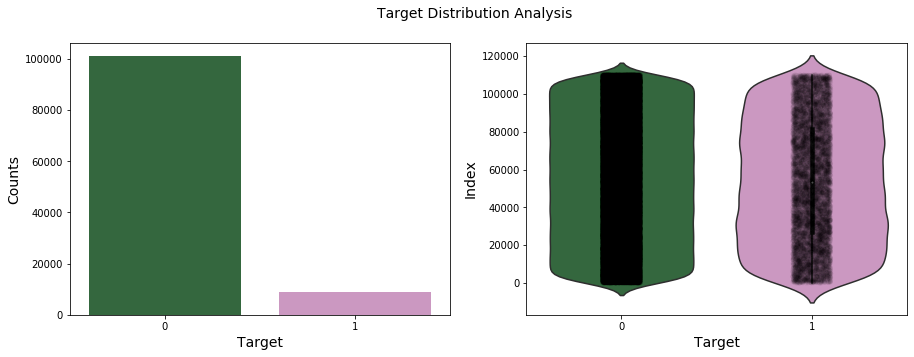

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(train.TARGET.mean(), 4)}")

sns.countplot(train.TARGET, ax=axes[0], palette="cubehelix")
sns.violinplot(train.TARGET, train.index, ax=axes[1], palette="cubehelix")
sns.stripplot(train.TARGET, train.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

Мы имеем достаточно большой дисбаланс классов, но целевая переменная распределена достаточно равномерно вдоль индексов тренировочного датасета

# validation

Поскольку данных в датасете довольно много, и дисбаланс целевой переменной хоть и выражен, но не критичен, применим простую hold-out валидацию на 3 выборки

In [46]:
x_train, x_valid = train_test_split(
    train.drop(["TARGET"], axis=1), train_size=0.6, random_state=27, shuffle=True
)
    
y_train, y_valid = train_test_split(
    train["TARGET"], train_size=0.6, random_state=27, shuffle=True
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.5, random_state=72, shuffle=True
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.5, random_state=72, shuffle=True
)

In [47]:
print("train.shape = {} rows, {} cols".format(*x_train.shape))
print("valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("test.shape = {} rows, {} cols".format(*x_test.shape))

train.shape = 66055 rows, 309 cols
valid.shape = 22019 rows, 309 cols
test.shape = 22019 rows, 309 cols


# model

In [48]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(2)

Categorical Feature Count 4


,NAME_CONTRACT_TYPE,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
0,Cash,M,Secondary / secondary special,Married
1,Cash,NaN,NaN,NaN


In [49]:
categorical_features_list = categorical_features.columns.tolist()

In [50]:
x_train[categorical_features_list] = x_train[categorical_features_list].astype(str)
x_valid[categorical_features_list] = x_valid[categorical_features_list].astype(str)
x_test[categorical_features_list] = x_test[categorical_features_list].astype(str)

In [51]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = cb.CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model

def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")


In [52]:
cb_params_1000 = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical_features_list, x_valid, y_valid)

0:	test: 0.5100185	best: 0.5100185 (0)	total: 203ms	remaining: 3m 22s
10:	test: 0.6041949	best: 0.6051361 (8)	total: 1.8s	remaining: 2m 41s
20:	test: 0.6348518	best: 0.6348518 (20)	total: 3.31s	remaining: 2m 34s
30:	test: 0.6441756	best: 0.6441756 (30)	total: 4.77s	remaining: 2m 29s
40:	test: 0.6441003	best: 0.6441756 (30)	total: 6.24s	remaining: 2m 25s
50:	test: 0.6445632	best: 0.6449743 (47)	total: 7.62s	remaining: 2m 21s
60:	test: 0.6647086	best: 0.6659232 (59)	total: 8.96s	remaining: 2m 17s
70:	test: 0.6632622	best: 0.6659232 (59)	total: 10.2s	remaining: 2m 13s
80:	test: 0.6653091	best: 0.6659232 (59)	total: 11.2s	remaining: 2m 6s
90:	test: 0.6660461	best: 0.6675337 (88)	total: 12.1s	remaining: 2m
100:	test: 0.6699794	best: 0.6709059 (99)	total: 13s	remaining: 1m 55s
110:	test: 0.6754274	best: 0.6754274 (110)	total: 13.8s	remaining: 1m 50s
120:	test: 0.6799898	best: 0.6799898 (120)	total: 14.6s	remaining: 1m 46s
130:	test: 0.6837295	best: 0.6837295 (130)	total: 15.4s	remaining: 1m 

In [53]:
evaluate_model(model, x_train, y_train, x_valid, y_valid)

score = 0.737354
score = 0.71762


# predict test data

In [54]:
test[categorical_features_list] = test[categorical_features_list].astype(str)

In [59]:
predictions = model.predict_proba(test)[:, 1]

In [60]:
df = pd.DataFrame({'APPLICATION_NUMBER': test['APPLICATION_NUMBER'].values, 'TARGET': predictions})
df.head(2)

,APPLICATION_NUMBER,TARGET
0,123724268,0.088766
1,123456549,0.171231


In [61]:
df.to_csv('ASirotkin.csv', index=False)

In [58]:
df.TARGET.value_counts()

0.0    165128
1.0        13
Name: TARGET, dtype: int64